<a href="https://colab.research.google.com/github/CobaMasa/RStan2PyStan/blob/20200422/chapter8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.markers import MarkerStyle

import seaborn as sns

import pystan
from statsmodels.api import formula as smf
import statsmodels.api as sm

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
salary3= pd.read_csv('drive/My Drive/Colab/RStanBook/chap08/input/data-salary-3.txt')
print('shape: ', salary3.shape)
salary3.head()

shape:  (300, 4)


,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


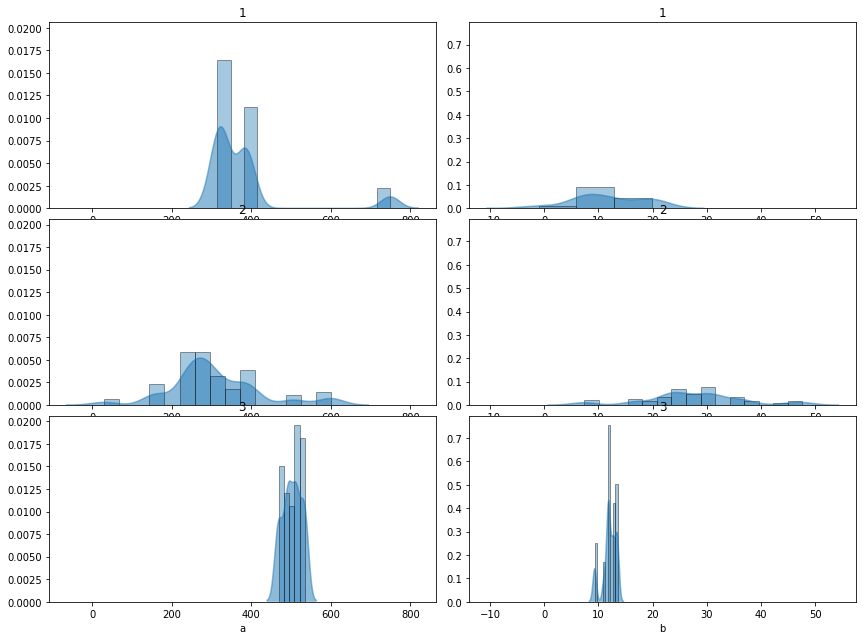

In [3]:
# pre estimation
## Estimate Y[n]~N(ai + biX[n], s_Yi) (i=unique KIDs: 30) linear models by each groups separately
KID_SimpleRegs = salary3.groupby(by='KID').apply(lambda d: smf.ols('Y~X', data=d).fit().params.rename({'Intercept': 'a', 'X': 'b'})).reset_index()
d_plot = pd.merge(KID_SimpleRegs, salary3[['KID', 'GID']], on='KID', how='left')[['a', 'b', 'KID', 'GID']]
d_plot

# plot Parameters destribution categorized by GIDs
hist_kwgs={'histtype': 'barstacked', 'edgecolor': 'black'}
kde_kwgs={'shade': True, 'alpha': 0.5}

fig = plt.figure(figsize=(12, 9))
gs_master = GridSpec(nrows=3, ncols=2)

gs_a = GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs_master[:, 0])
for row, gid in enumerate(d_plot.GID.unique()):
    ax = fig.add_subplot(gs_a[row, 0], sharex=ax if row>0 else None, sharey=ax if row>0 else None)
    sns.distplot(d_plot.query('GID == @gid')['a'], ax=ax, hist_kws=hist_kwgs, kde_kws=kde_kwgs)
    plt.setp(ax, title=gid)

gs_b = GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs_master[:, 1])
for row, gid in enumerate(d_plot.GID.unique()):
    ax = fig.add_subplot(gs_b[row, 0], sharex=ax if row>0 else None, sharey=ax if row>0 else None)
    sns.distplot(d_plot.query('GID == @gid')['b'], ax=ax, hist_kws=hist_kwgs, kde_kws=kde_kwgs)
    plt.setp(ax, title=gid)

plt.tight_layout()
plt.show();

## Modeling
$$
\begin{eqnarray}
    Y[n]&〜&Normal(a[KID[n]]+b[KID[n]]X[n], \sigma_Y)\\
    a_{Gmean}[g]&〜&Normal(a_{global}, \sigma_{ag})\\
    b_{Gmean}[g]&〜&Normal(b_{global}, \sigma_{bg})\\
    a[k]&〜&Normal(a_{Gmean}[K2G[k]], \sigma_a)\\
    b[k]&〜&Normal(b_{Gmean}[K2G[k]], \sigma_b)
\end{eqnarray}
$$

In [4]:
files.upload()

Saving model8-6.stan to model8-6 (1).stan


{'model8-6.stan': b'data {\n  int N;\n  int K;\n  int G;\n  real X[N];\n  real Y[N];\n  int<lower=1, upper=K> KID[N];\n  int<lower=1, upper=G> GID[N];\n  int<lower=1, upper=G> K2G[K];\n}\n\nparameters {\n  real a0;\n  real b0;\n  real a1[G];\n  real b1[G];\n  real a[K];\n  real b[K];\n  real<lower=0> s_ag;\n  real<lower=0> s_bg;\n  real<lower=0> s_Y[G];\n  real<lower=0> s_a[G];\n  real<lower=0> s_b[G];\n}\n\nmodel {\n  for (g in 1:G) {\n    a1[g] ~ normal(a0, s_ag);\n    b1[g] ~ normal(b0, s_bg);\n  }\n\n  for (k in 1:K) {\n    a[k] ~ normal(a1[K2G[k]], s_a[K2G[k]]);\n    b[k] ~ normal(b1[K2G[k]], s_b[K2G[k]]);\n  }\n\n  for (n in 1:N) {\n    Y[n] ~ normal(a[GID[n]]+b[GID[n]]*X[n], s_Y[GID[n]]);\n  }\n}\n'}

In [0]:
salary3

StanData = {
    'N': salary3.shape[0],
    'K': salary3.KID.max(),
    'G': salary3.GID.max(),
    'X': salary3.X.values,
    'Y': salary3.Y.values,
    'KID': salary3.KID.values,
    'K2G': salary3.drop_duplicates(subset=['KID', 'GID'])['GID']
}

In [6]:
sm = pystan.StanModel(file='model8-5.stan')
fit = sm.sampling(data=StanData, n_jobs=-1)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0aa61fec39db91821c05e67ea05d6479 NOW.


Inference for Stan model: anon_model_0aa61fec39db91821c05e67ea05d6479.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0    355.62   25.37 498.81 -321.9  304.6 383.82 457.84 958.31    387   1.01
b0     17.93    0.83  30.29  -35.6  11.63   18.3  25.25  70.36   1331    1.0
a1[1] 358.54    0.77  30.14 298.43 338.79 359.44 378.31 416.65   1543    1.0
a1[2] 299.26    0.43  14.23 270.69 289.76  299.3 308.71 327.56   1084    1.0
a1[3] 497.03    1.04   30.1 437.29 477.58  495.9 516.03 557.28    839   1.01
b1[1]  13.11    0.06   2.81   7.72   11.1  13.07  15.03  18.51   2202    1.0
b1[2]  28.61    0.03   1.35  26.03  27.71  28.61  29.49  31.29   1739    1.0
b1[3]  12.66    0.08   2.55   7.59  10.98   12.7  14.33  17.62   1102   1.01
a[1]  364.62    0.66  26.96 310.43  346.5 364.29 383.32 415.94   1671    1.0
a[2]  356.26    0.68  28.76 297.84 337.68

Set diffenrent variance parameters by GID

$$
\begin{eqnarray}
    Y[n]&〜&Normal(a[KID[n]]+b[KID[n]]X[n], \sigma_Y[GID[n]])\\
    a[k]&〜&Normal(a_{Gmean}[K2G[k]], \sigma_a[K2G[[k]])\\
    b[k]&〜&Normal(b_{Gmean}[K2G[k]], \sigma_b[K2G[k]])
\end{eqnarray}
$$

($a_{Gmean}[G]$and $b_{Gmean}[G]$ are estimated from the above quations. i.g)$Normal(a_{global}, \sigma{a})$)

In [0]:
StanData = {
    'N': salary3.shape[0],
    'K': salary3.KID.max(),
    'G': salary3.GID.max(),
    'X': salary3.X.values,
    'Y': salary3.Y.values,
    'KID': salary3.KID.values,
    'GID': salary3.GID.values,
    'K2G': salary3.drop_duplicates(subset=['KID', 'GID'])['GID']
}

In [9]:
sm = pystan.StanModel(file='model8-6.stan')
fit = sm.sampling(data=StanData, n_jobs=-1)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_98e8da7f008398f539e9e245edea24ff NOW.


Inference for Stan model: anon_model_98e8da7f008398f539e9e245edea24ff.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0       1.5e9   9.2e8  4.8e9  -1.9e9 -3.1e6  8.2e7  8.3e8 1.8e10     27   1.14
b0       2.0e9   1.5e9 1.1e10 -2.0e10 -3.5e8 -6.0e7  1.1e9 3.5e10     51    1.1
a1[1]   237.04  175.61 1794.8  -728.7 316.83  392.7 466.36 1194.0    104   1.03
a1[2]    4.4e8   6.6e8  1.3e9  -2.4e9  2.8e5  4.1e7  7.3e8  3.7e9      4    1.7
a1[3]    2.0e9   8.9e8  5.8e9  -4.9e9 -4.4e6  1.5e8  1.4e9 2.0e10     43   1.08
b1[1]    12.99    2.27 118.54  -82.03  10.37  17.02  24.72 104.01   2732    1.0
b1[2]    3.6e9   3.1e9 1.1e10  -7.4e9 -2.7e8 -1.0e7  1.1e9 4.0e10     13   1.25
b1[3]    3.9e9   2.8e9 1.2e10 -1.3e10 -5.2e8 -1.2e7  3.5e9 4.2e10     19   1.21
a[1]    376.02    0.44   24.5  327.55 360.42  375.7 392.09 424.32   3144    1.0
a[2]     31

In [0]:
# The more models become complex (like having many parameters), the harder the models get convergent.
# This often drives from the amount of data, which is relatevely small comparing to model complexity.
## In that case, we can 1. just use more simple model, or 2. add more restructions 'weakly informative prior' distributions.